# Clustering ECG Data

In [1]:
import random
import pickle
from IPython.display import Image
from IPython.display import display
from tqdm import tqdm
from tabulate import tabulate
from fastdtw import fastdtw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import signal
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

In [2]:
plt.rcParams["figure.figsize"]  = (10, 5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color']     = 'b'
plt.rcParams['axes.grid']       = True 

In [3]:
IMG_COUNT = 0

def savefig():
    global IMG_COUNT

    IMG_COUNT = IMG_COUNT + 1
    plt.savefig(f"img/{IMG_COUNT}.png", dpi=400, bbox_inches='tight')

## Data

In [4]:
f = open('X.pkl', 'rb')
X = pickle.load(f)
f.close()

f = open('y.pkl', 'rb')
y = pickle.load(f)
f.close()

In [5]:
def randplt(X, n):
    """
    Pick random n records from X and plot them
    overlapping each other
    """
    random.seed(11)
    
    for i in random.sample(range(len(X)), n):
        plt.plot(X[i])
    
    savefig()
       
    plt.show()

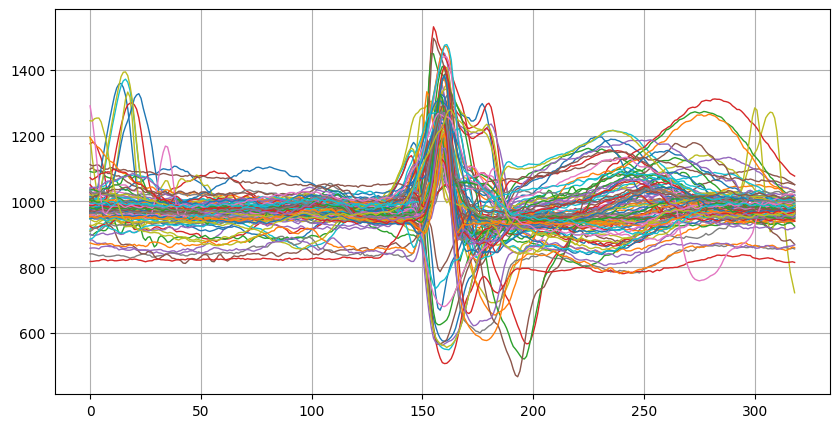

In [6]:
randplt(X, 100)

### Normalizing

In [7]:
for i in tqdm(range(len(X))):
    """
    min: 0
    max: 1
    """
    X[i] = (X[i] - np.min(X[i])) / (np.max(X[i]) - np.min(X[i]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42021/42021 [00:02<00:00, 15548.32it/s]


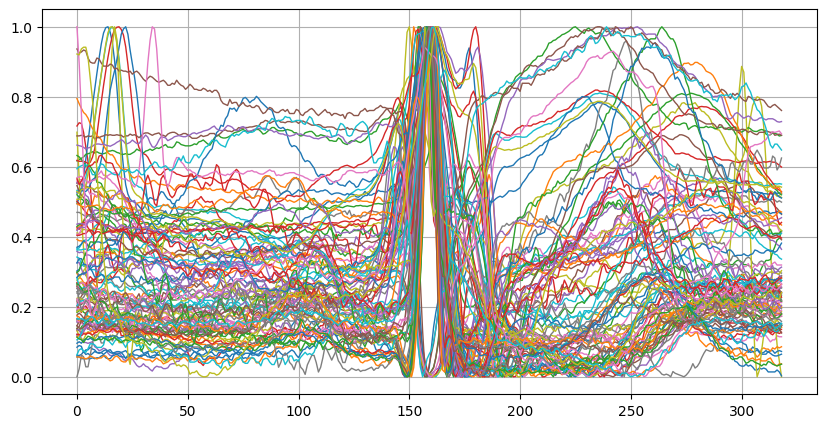

In [8]:
randplt(X, 100)

### Denoising ECG signals using Butterworth filter

In [9]:
X_b = []

# Butterworth filter
for i in tqdm(range(len(X))):
    lowcut = 0.5         # Lower cutoff frequency in Hz
    highcut = 100        # Upper cutoff frequency in Hz
    order = 4            # Filter order
    sampling_rate = 360  # Replace with your sampling rate
    
    # Normalize cutoff frequencies
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design a Butterworth bandpass filter
    b, a = signal.butter(order, [low, high], btype='band')
    
    # Apply the filter to the ECG signal
    X_b.append(signal.filtfilt(b, a, X[i]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42021/42021 [00:10<00:00, 3968.43it/s]


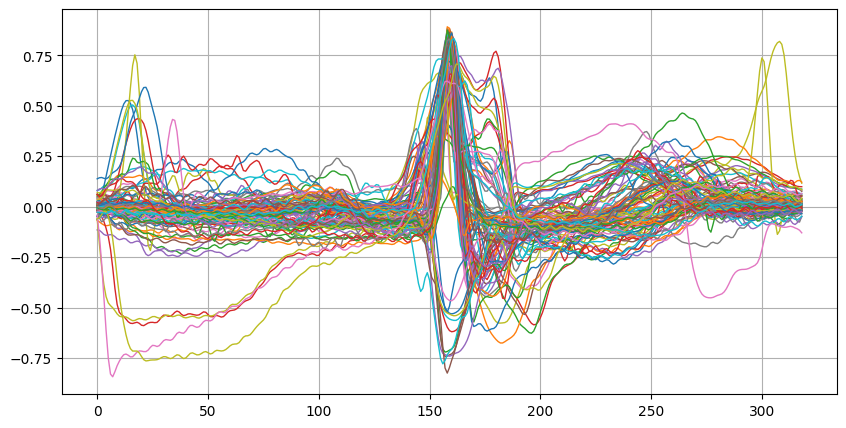

In [10]:
randplt(X_b, 100)

### Segmentation

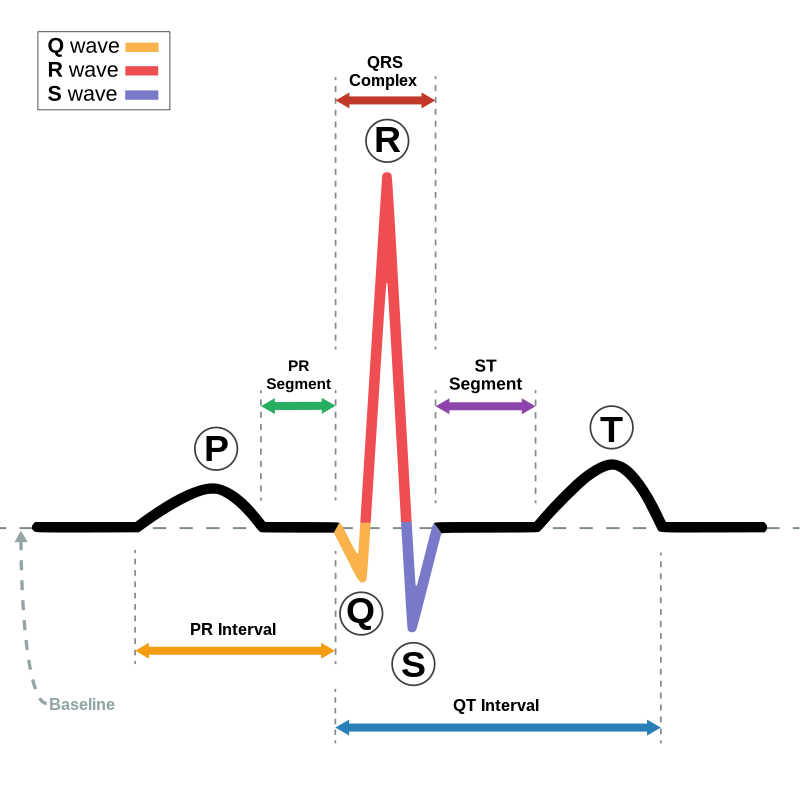

In [11]:
display(Image(filename='SinusRhythmLabels.png', width=600))

Extract QRS complex from the ECG waves

In [12]:
for i in tqdm(range(len(X))):
    X[i] = X_b[i][125:225 + 1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42021/42021 [00:00<00:00, 1263677.19it/s]


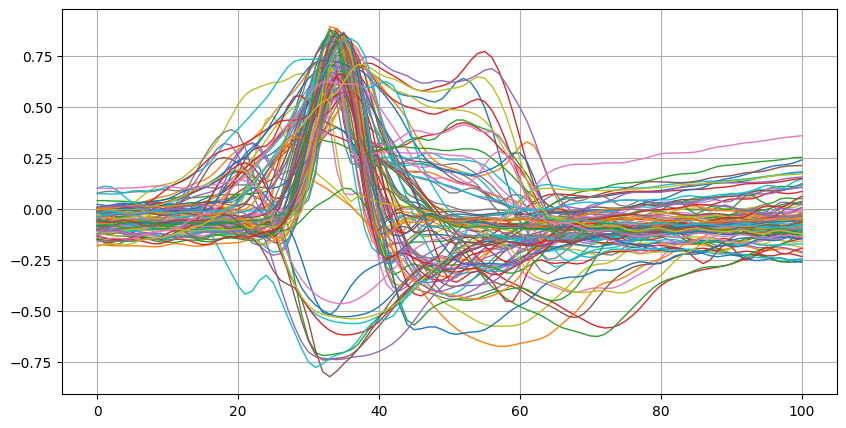

In [13]:
randplt(X, 100)

In [14]:
f = open('X-norm-den-seg.pkl', 'wb')
pickle.dump(X, f)
f.close()

In [15]:
f = open('X-norm-den-seg.pkl', 'rb')
X = pickle.load(f)
f.close()

### Distance Matrix

In [16]:
def dist(X, i, j):
    """
    Calculate pairwise distances
    """
    if i == j:
        D[i, j] = 0
        
    elif D[i, j] == 0:
        # DTW
        # d, _ = fastdtw(X[i], X[j])

        # Cosine similarity
        # d = np.dot(X[i], X[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(X[j]))

        # Pearson correlation
        # d = np.corrcoef(X[i], X[j])[0, 1]
        
        D[i, j] = d
        D[j, i] = d

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

y_counts = Counter(y)

# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={
    0: 1500,
    1: 1500,
    2: 1500,
    3: 1500,
    4: 1500,
    5: 1500,
})

# Perform random undersampling
U, v = undersampler.fit_resample(X, y)
v_counts = Counter(v)

table = []
for key in y_counts.keys():
    table.append([key, y_counts[key], v_counts[key]])

print(tabulate(table, headers=['Class', 'y', 'v']))

  Class     y     v
-------  ----  ----
      0  9997  1500
      3  2546  1500
      4  7129  1500
      5  7023  1500
      1  8071  1500
      2  7255  1500


In [18]:
len_U = len(U)

# Compute distance matrix
# D = np.zeros((len_U, len_U))

# for i in tqdm(range(len_U)):
#     for j in range(len_U):
#         dist(U, i, j)

D = 1 - cosine_similarity(U)

In [19]:
f = open('D-cosine.pkl', 'wb')
pickle.dump(D, f)
f.close()

In [20]:
f = open('D-cosine.pkl', 'rb')
D = pickle.load(f)
f.close()

### KMeans

+------------+---------------------------+
|   Clusters |   Average Silhoutte Score |
|------------+---------------------------|
|          2 |                  0.741523 |
|          3 |                  0.474664 |
|          4 |                  0.486036 |
|          5 |                  0.504001 |
|          6 |                  0.545035 |
|          7 |                  0.502724 |
|          8 |                  0.485831 |
|          9 |                  0.454413 |
+------------+---------------------------+


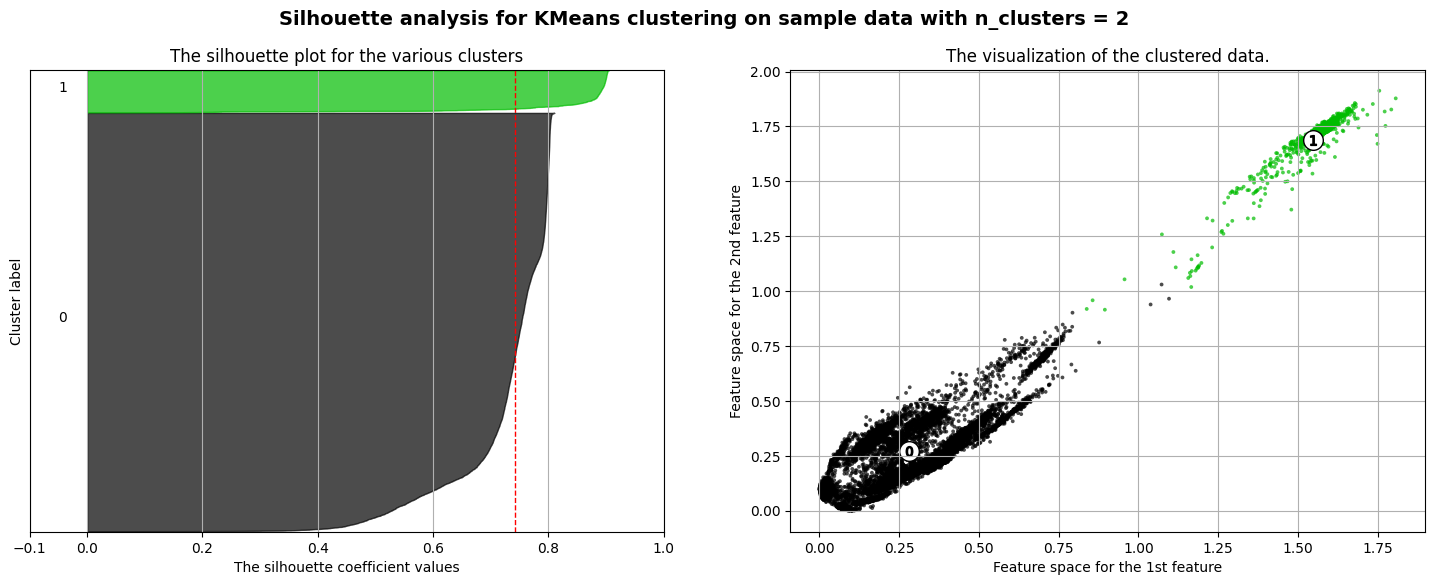

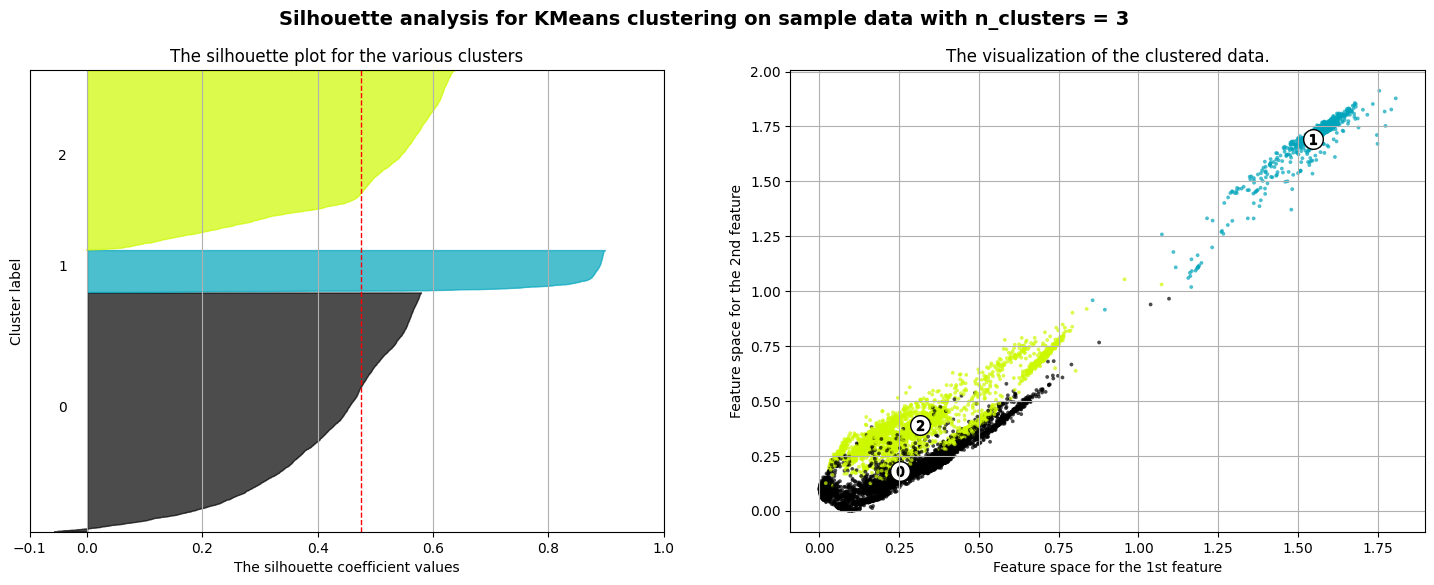

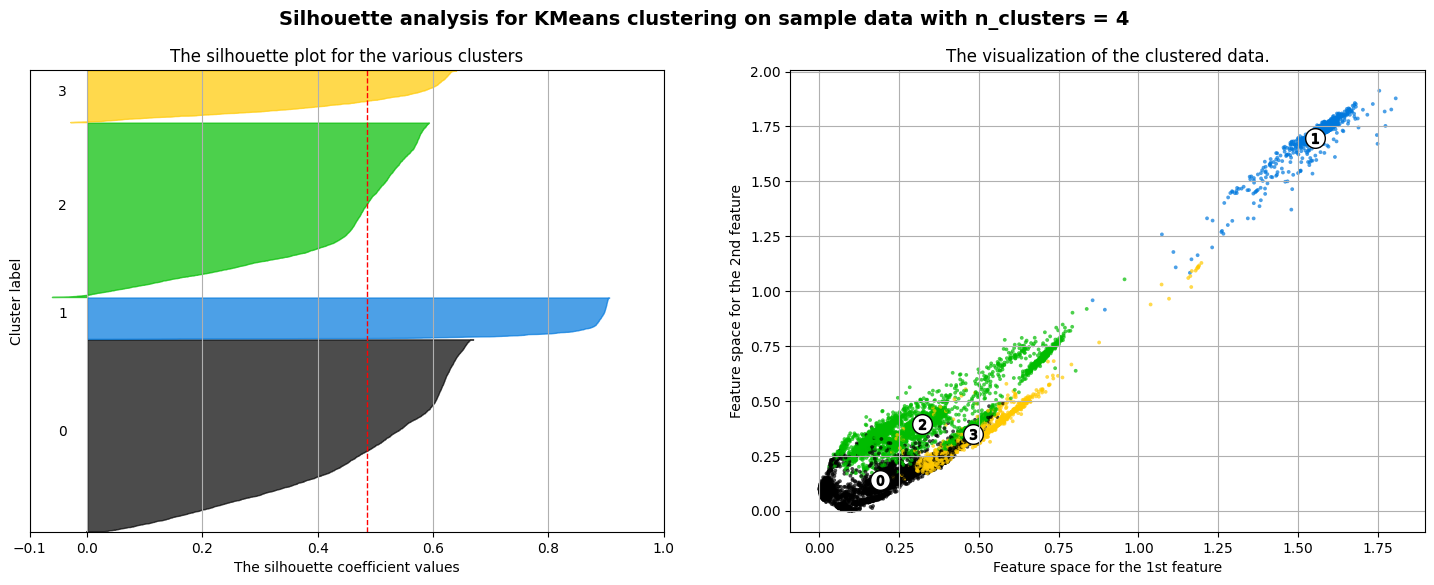

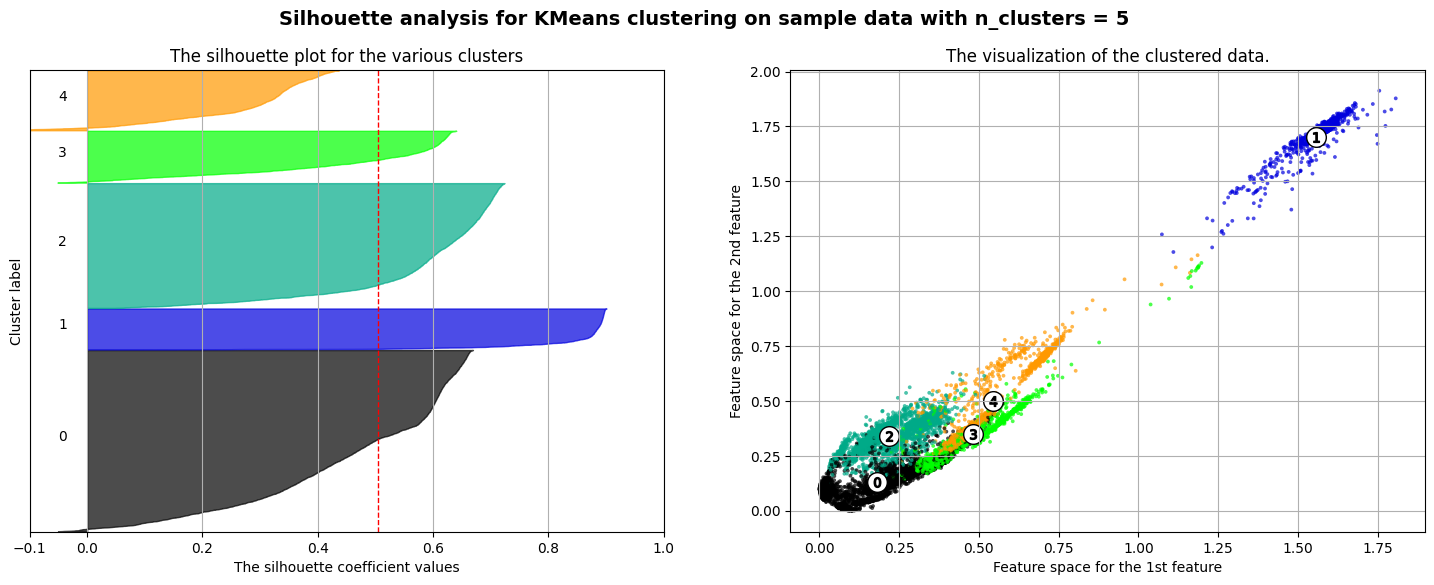

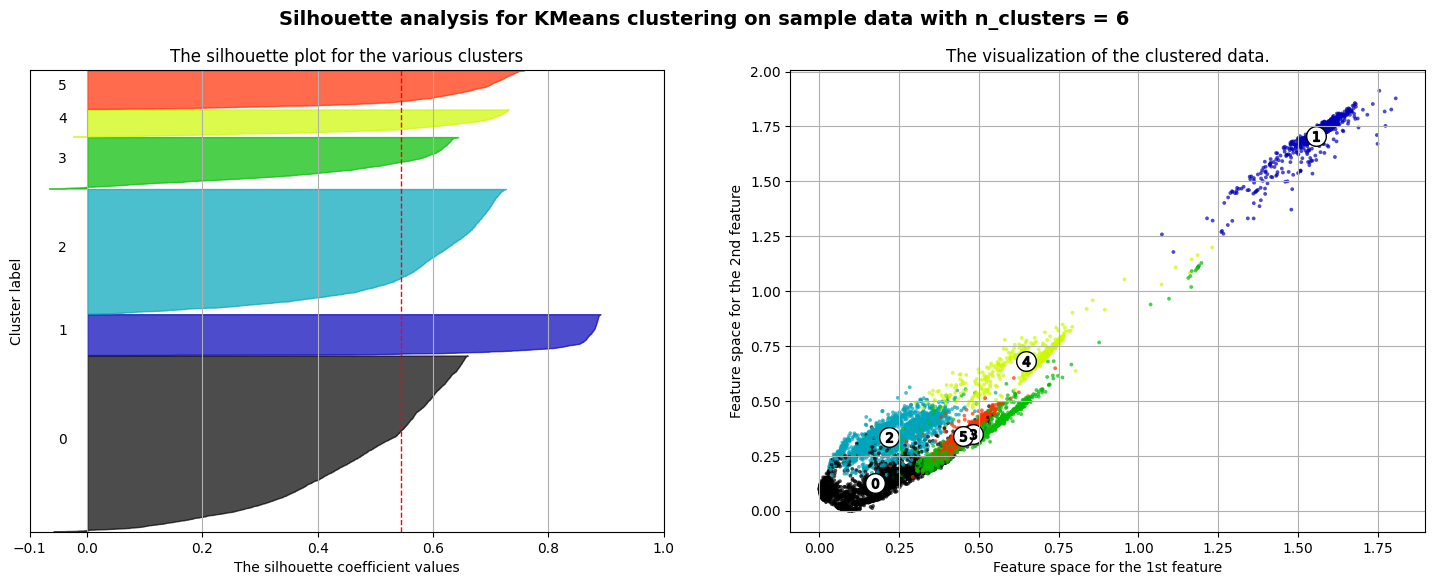

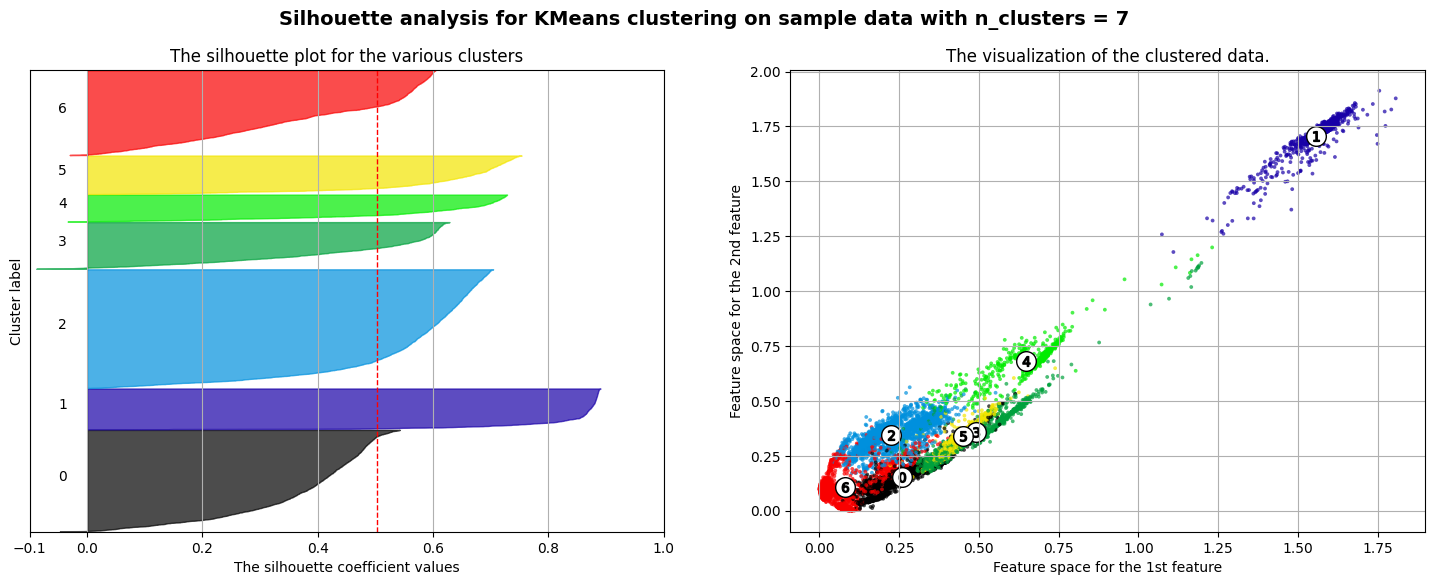

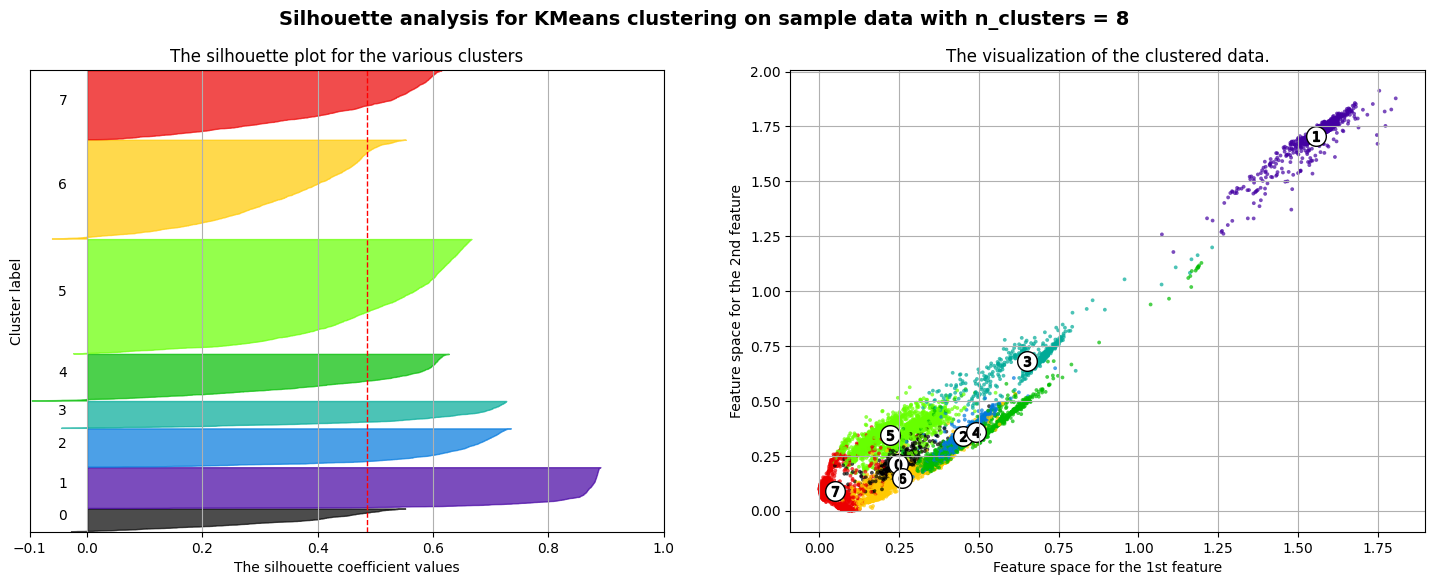

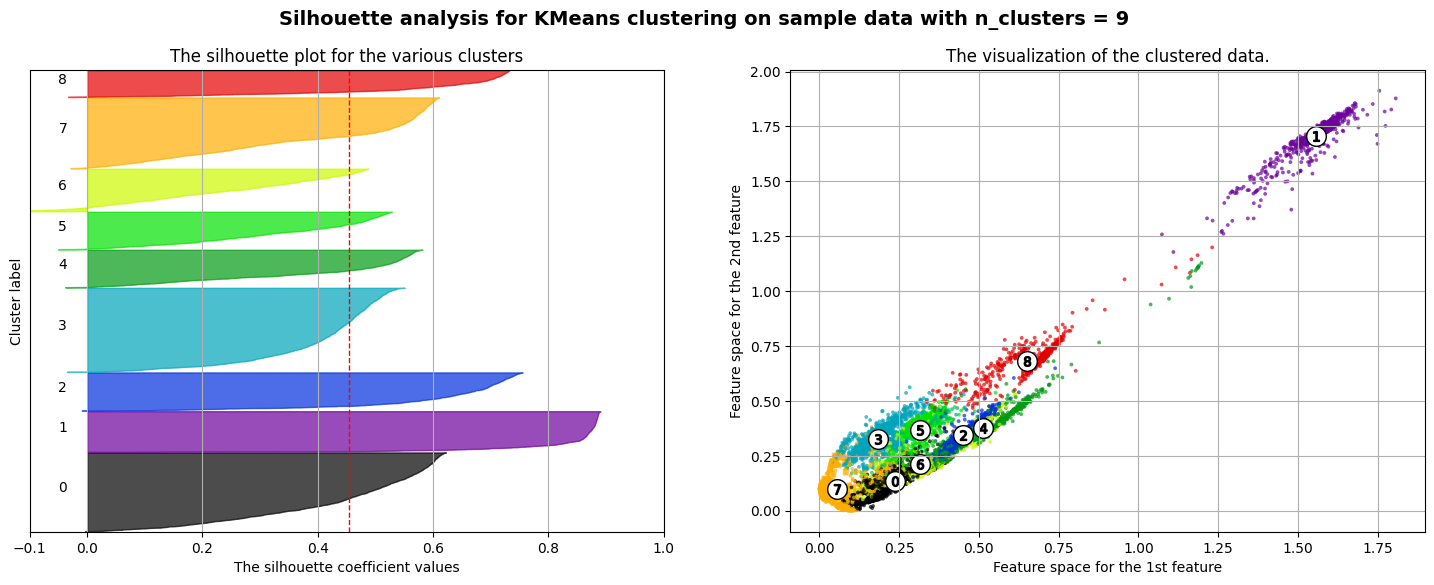

In [21]:
from sklearn.cluster import KMeans

table = []

for n_clusters in range(2, 10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 6)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(D) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=11)
    labels    = clusterer.fit_predict(D)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_score_average = silhouette_score(D, labels)
    table.append([n_clusters, silhouette_score_average])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(D, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_score_average, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
    ax2.scatter(
        D[:, 0], D[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    savefig()
    
print(tabulate(table, headers=['Clusters', 'Average Silhoutte Score'], tablefmt='psql'))  
plt.show()

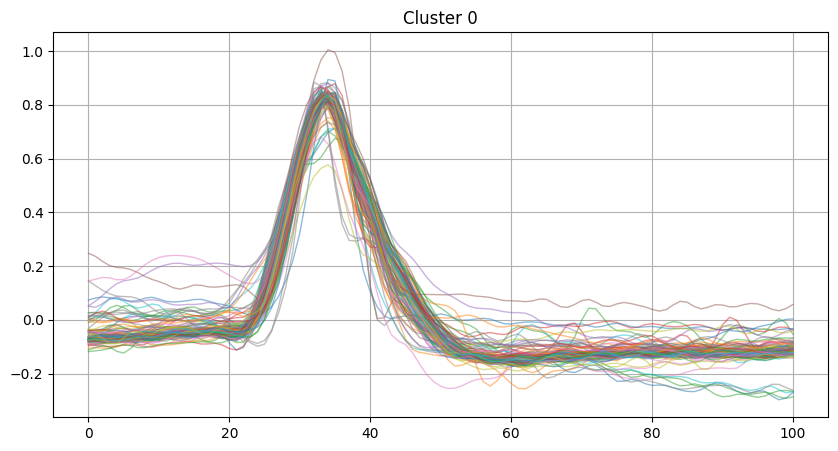

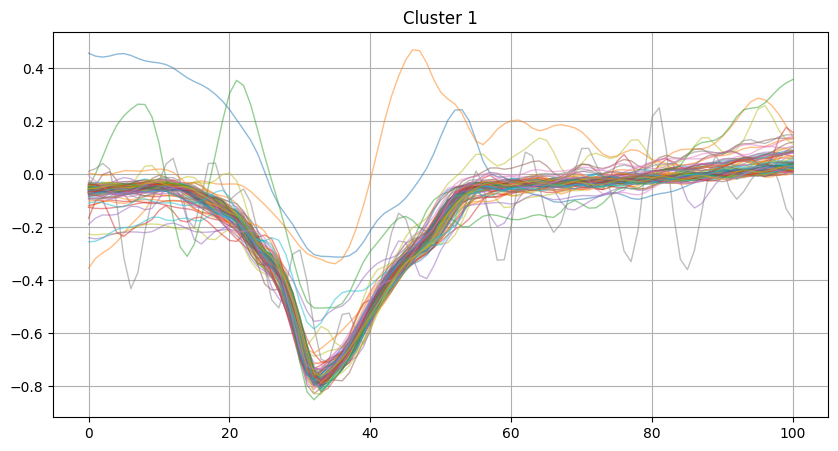

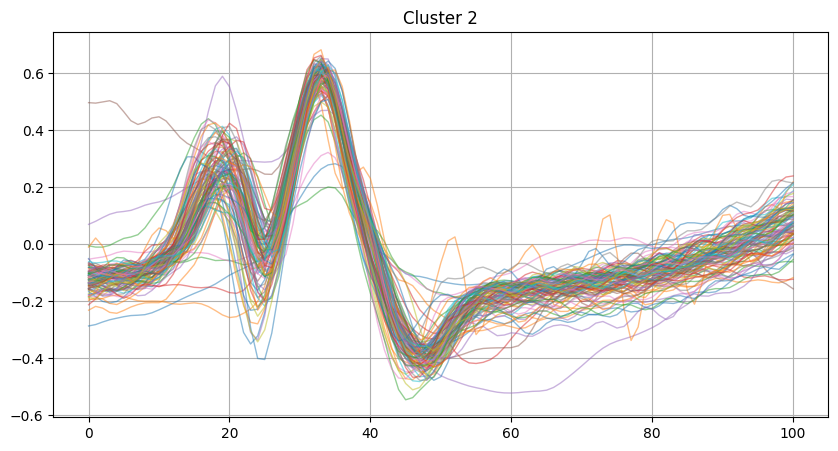

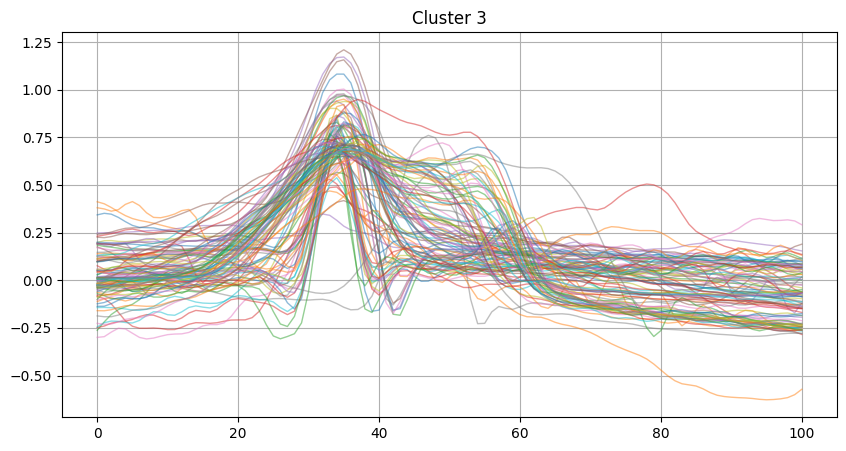

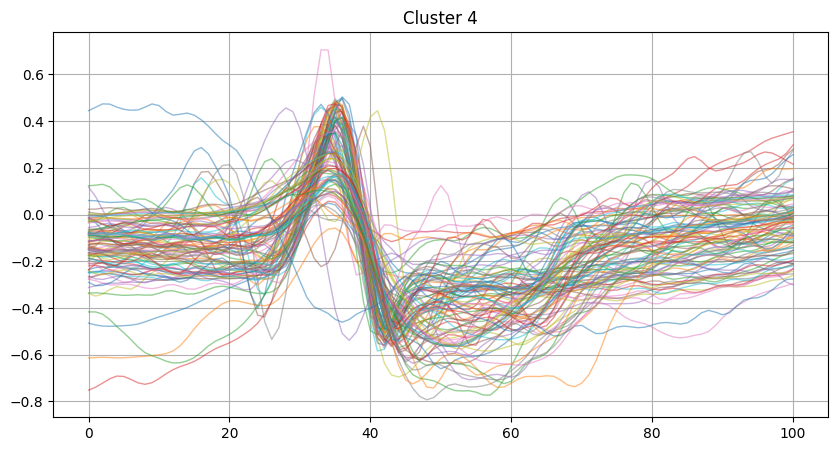

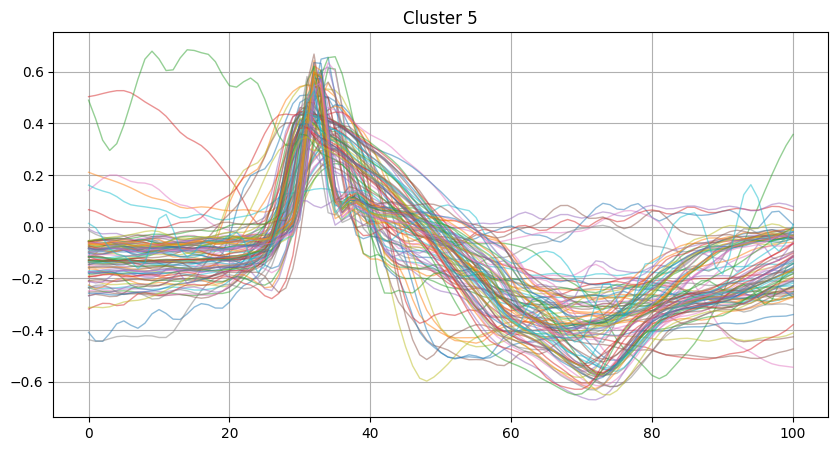

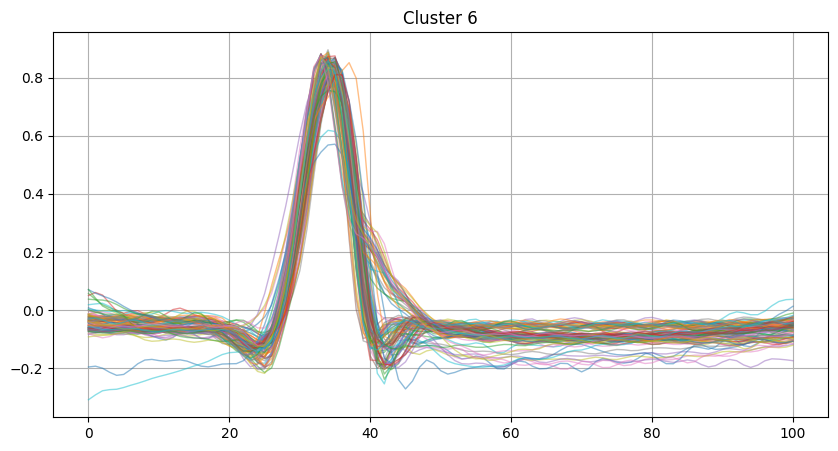

In [22]:
 n_clusters = 7

kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=11)
kmeans.fit(D)

# Plot each cluster separately with overlapping waves
for cluster in set(kmeans.labels_):
    n = 100
    plt.title(f"Cluster {cluster}")
    for i in range(len_U):
        if kmeans.labels_[i] == cluster:
            if n > 0:
                plt.plot(U[i], label=f"Time Series {i}", alpha=0.5)
                n = n - 1
    savefig()
    plt.show()

### Hierarchial Clustering

In [23]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

L = linkage(D, method='average')

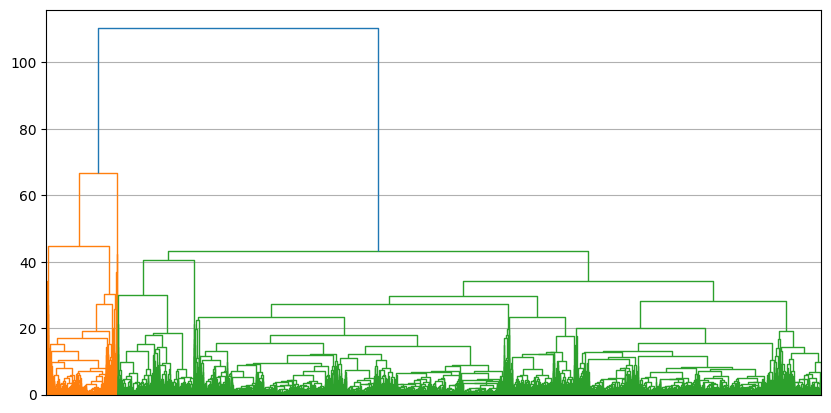

In [24]:
dendrogram(L, orientation='top', distance_sort='descending', no_plot=False, no_labels=True)
savefig()
plt.show()

### DBSCAN

In [25]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=50)
labels = dbscan.fit_predict(U)

silhouette_score(U, labels)

0.46468401041468566

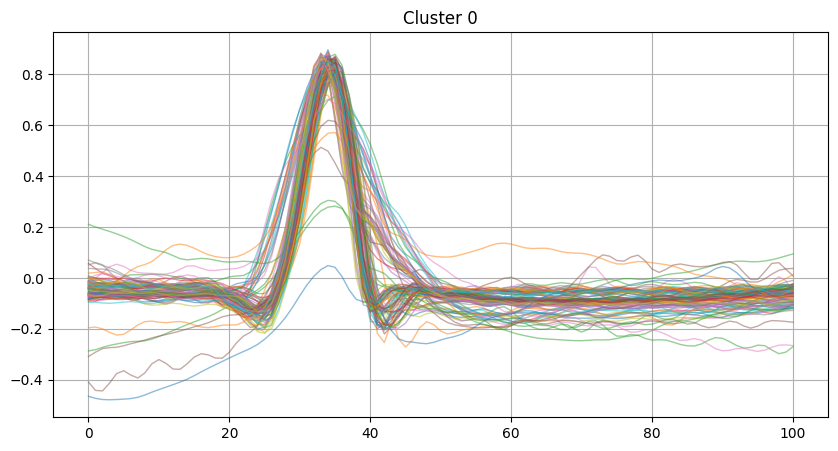

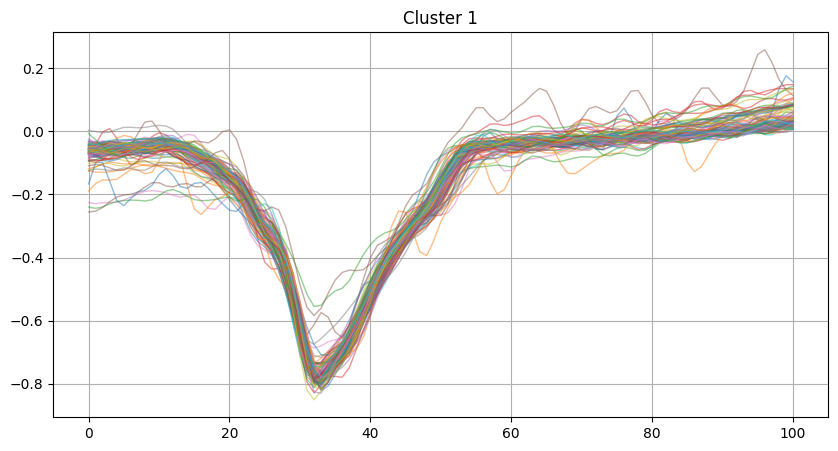

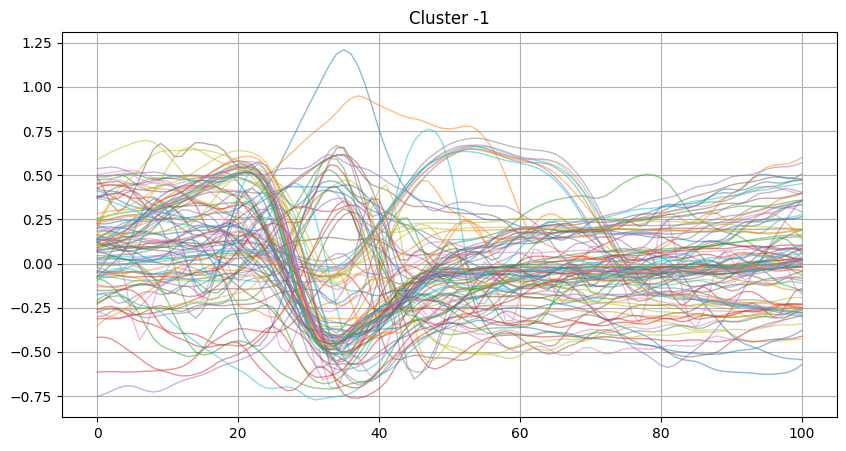

In [26]:
# Plot each cluster separately with overlapping waves
for label in set(labels):
    n = 100
    plt.title(f"Cluster {label}")
    for i in range(len_U):
        if labels[i] == label:
            if n > 0:
                plt.plot(U[i], label=f"a{i}", alpha=0.5)
                n = n - 1
    savefig()
    plt.show()

### GMM

In [27]:
from sklearn.mixture import GaussianMixture

best_score        = -1
best_labels       = None 
best_n_components = None

for n_components in tqdm(range(1, 11)):
    gmm = GaussianMixture(n_components=n_components, random_state=11)
    labels = gmm.fit_predict(U)

    if len(set(labels)) < 2:
        continue
            
    silhouette = silhouette_score(U, labels)
        
    if silhouette > best_score:
        best_score        = silhouette
        best_labels       = labels
        best_n_components = n_components

best_n_components, best_score

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.40s/it]


(10, 0.2359894802288631)

In [28]:
gmm = GaussianMixture(n_components=best_n_components, random_state=11)
labels = gmm.fit_predict(U)

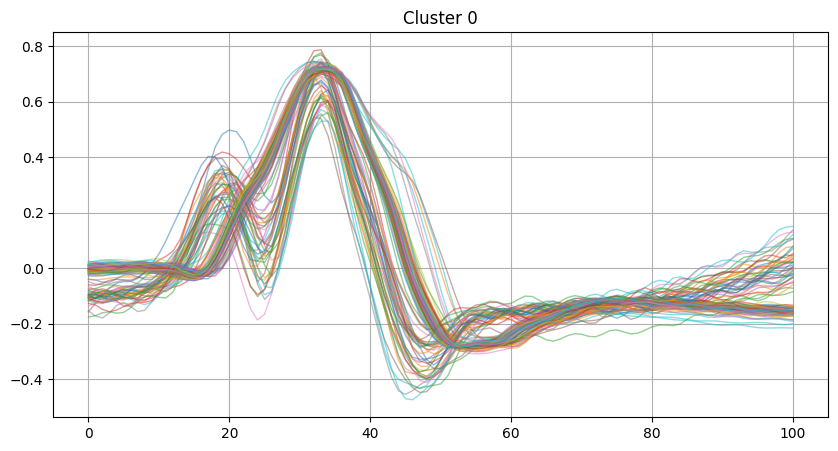

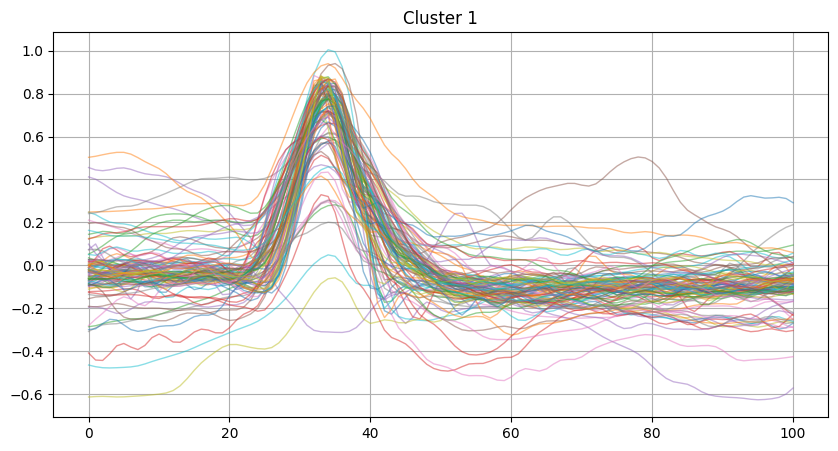

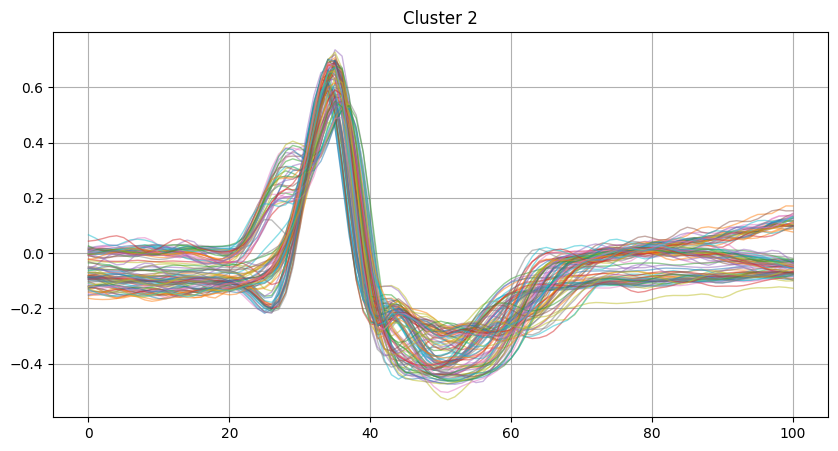

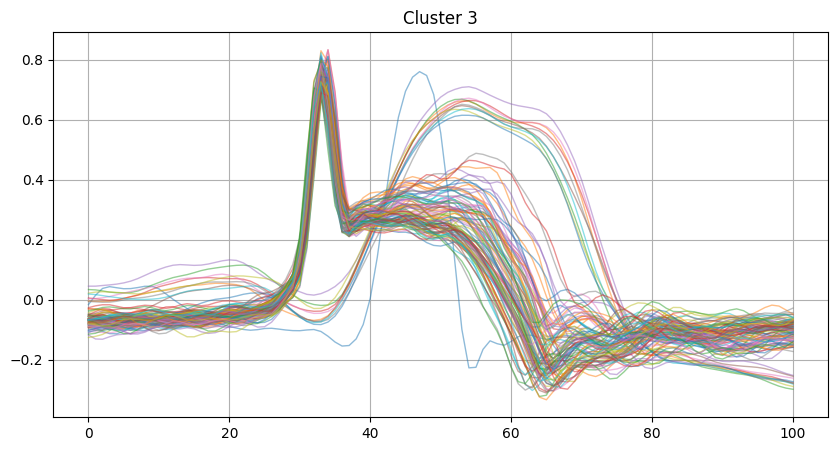

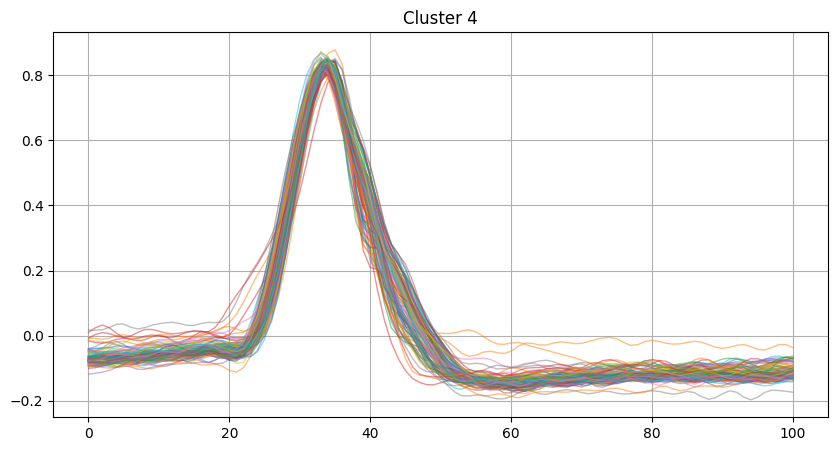

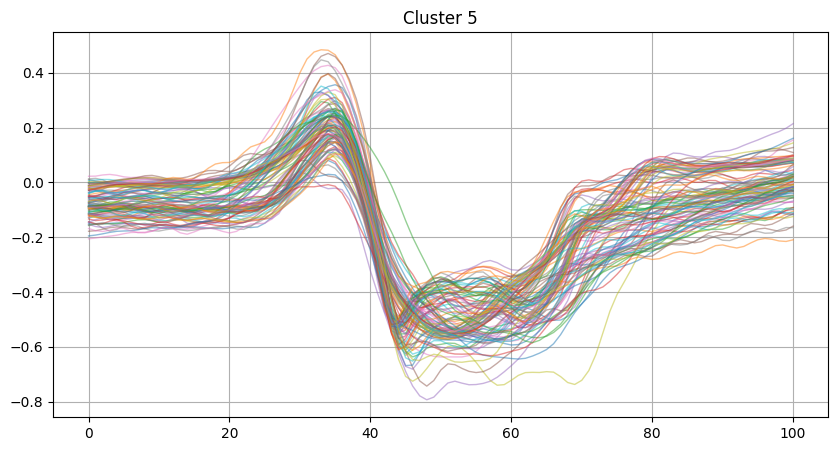

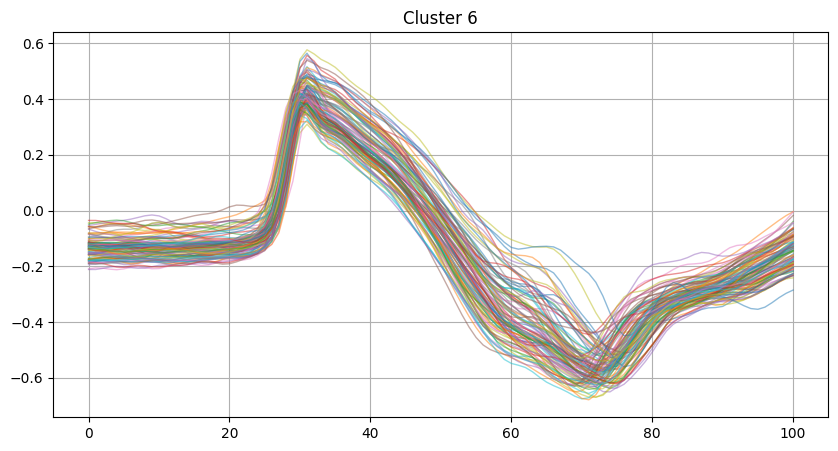

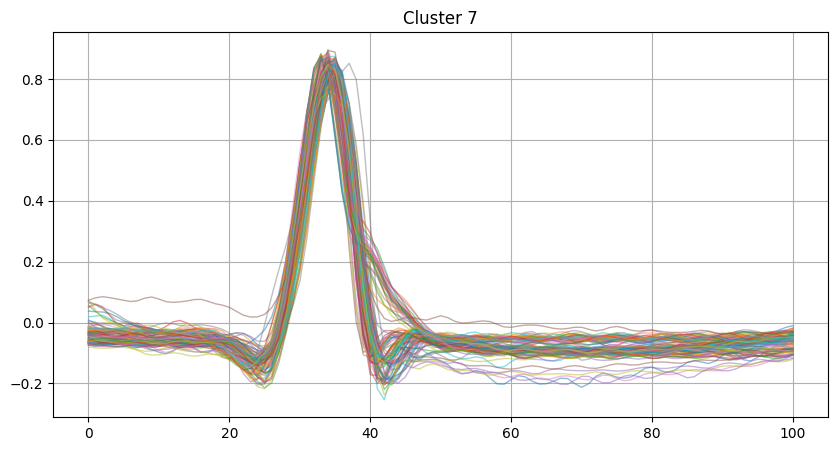

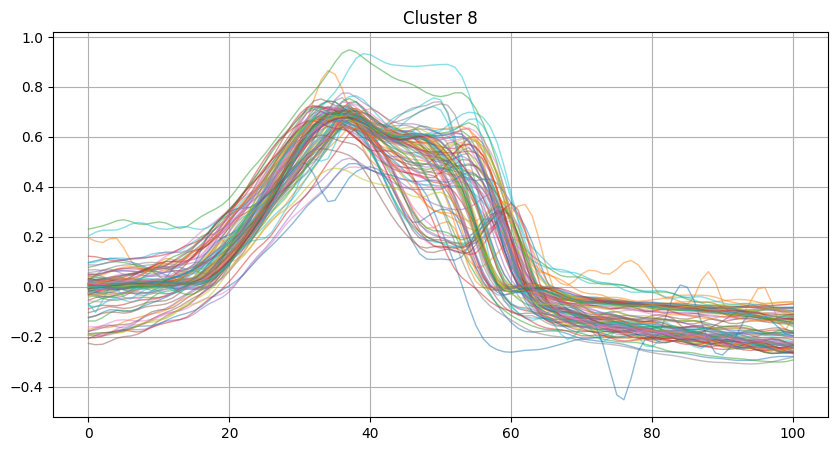

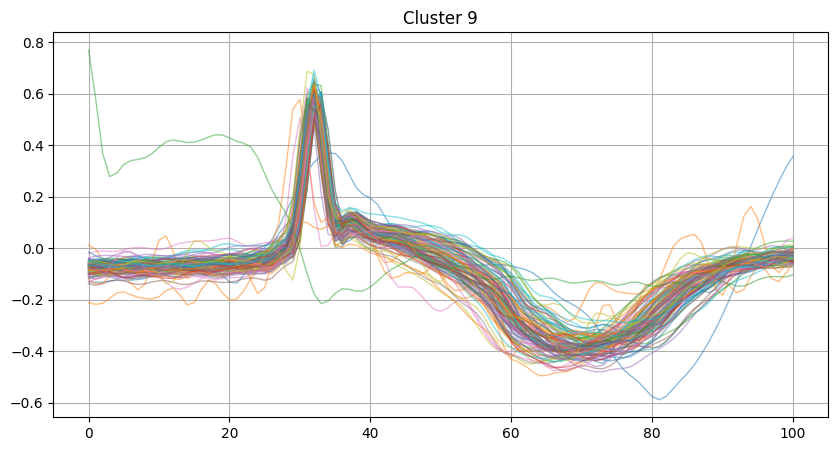

In [29]:
# Plot each cluster separately with overlapping waves
for cluster in set(labels):
    n = 100
    plt.title(f"Cluster {cluster}")
    for i in range(len_U):
        if labels[i] == cluster:
            if n > 0:
                plt.plot(U[i], label=f"Time Series {i}", alpha=0.5)
                n = n - 1
    savefig()
    plt.show()